In [1]:
import asyncio
import websockets
import json
import pandas as pd
import datetime as dt
import nest_asyncio
from concurrent.futures import ThreadPoolExecutor
nest_asyncio.apply()

import datetime
from pandas.io.json import json_normalize
import numpy as np
from scipy import interpolate
import statsmodels.api as sm
from scipy.stats import norm

from market_data import HistData
from market_data import Options

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# Strategy Outline
1. Short (lower strike) puts and (higher strike) calls
2. Strategy assumes vol will stay muted and we harvest theta yield over time
3. Find risk-neutral implied probabiltiies of option expiring in the money for the puts and calls
4. Short calls where the probability of the option expiring with price > chosen strike is less than 10% -15%
5. Short puts where the probability of the option expiring with price < chosen strike is less than 10%-15%
6. Stop-loss when probability of getting exercised by the expiry is > 60% - 70%.
6. In essence, probability of stopping out per trade will be 20%-30% at initiation since could be 60% at the highest (at which point we will stop out)

In [2]:
hdata = HistData('ETH')

## Options

In [3]:
opt = Options('ETH')

## Get all active Eth options

### Get actively traded option chains

In [4]:
option_chain_call= opt.get_option_chain(pd.datetime.today(),option_type='call')
option_chain_put= opt.get_option_chain(pd.datetime.today(),option_type='put')
option_chain_call['scaled_iv'] = option_chain_call['mark_iv']*np.sqrt(option_chain_call['dte']/360)
option_chain_put['scaled_iv'] = option_chain_put['mark_iv']*np.sqrt(option_chain_put['dte']/360)

750 active options.
1710462566309
Expiration Date:  2024-03-15 16:00:00
750 active options.
1710462572046
Expiration Date:  2024-03-15 16:00:00


In [5]:
curr_price = hdata.get_idx_price()
curr_price

2922.31

### Get Implied Probabilities
1. First method is to use the IV's themselves as the vol to calculate the implied probabilities
2. Second method is to use the atm strike's IV to calcualte the implied probabilities (Assumes a true normal distribution)

## Method 1

In [6]:
option_chain_call['implied_probability'] = 1-norm.cdf(option_chain_call['strike'].astype(float),loc = curr_price,scale=curr_price*option_chain_call['scaled_iv']/100)
option_chain_put['implied_probability'] = norm.cdf(option_chain_call['strike'].astype(float),loc = curr_price,scale=curr_price*option_chain_put['scaled_iv']/100)

In [7]:
option_chain_call=option_chain_call[option_chain_call['strike'].astype(float)>=curr_price]
option_chain_put=option_chain_put[option_chain_put['strike'].astype(float)<=curr_price]
option_chain_full = pd.concat([option_chain_put,option_chain_call])

<Axes: title={'center': 'Option Implied Probabilities of ETH Expiration Price'}, xlabel='strike'>

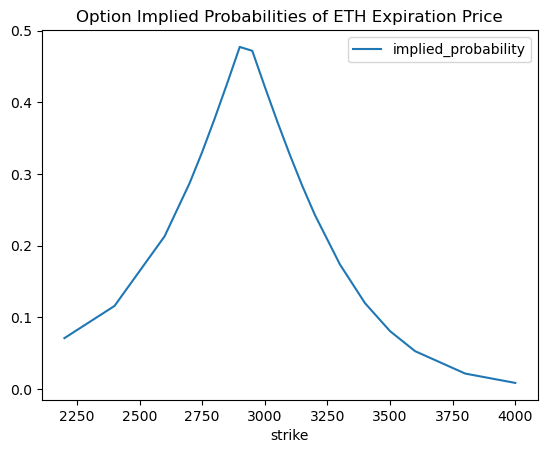

In [8]:
option_chain_full[['strike','implied_probability']].set_index('strike').plot(title='Option Implied Probabilities of ETH Expiration Price')

In [9]:
option_chain_full[['strike','implied_probability']]

,strike,implied_probability
0,2200.0,0.070956
0,2400.0,0.115875
0,2600.0,0.213073
0,2700.0,0.287360
0,2750.0,0.330653
0,2800.0,0.377450
0,2850.0,0.426671
0,2900.0,0.477319
0,2950.0,0.471882
0,3000.0,0.421786


## Method 2

In [9]:
option_chain_call= opt.get_option_chain(pd.datetime.today(),option_type='call')
option_chain_put= opt.get_option_chain(pd.datetime.today(),option_type='put')
option_chain_call['scaled_iv'] = option_chain_call['mark_iv']*np.sqrt(option_chain_call['dte']/360)
option_chain_put['scaled_iv'] = option_chain_put['mark_iv']*np.sqrt(option_chain_put['dte']/360)

664 active options.
1710196593572
Expiration Date:  2024-03-29 16:00:00
664 active options.
1710196601192
Expiration Date:  2024-03-29 16:00:00


In [10]:
call_iv = option_chain_call[option_chain_call['strike']==curr_price- curr_price%100]['scaled_iv'][0]
put_iv = option_chain_put[option_chain_put['strike']==curr_price- curr_price%100]['scaled_iv'][0]

In [11]:
option_chain_call['implied_probability'] = 1-norm.cdf(option_chain_call['strike'].astype(float),loc = curr_price,scale=curr_price*call_iv/100)
option_chain_put['implied_probability'] = norm.cdf(option_chain_call['strike'].astype(float),loc = curr_price,scale=curr_price*put_iv/100)

In [12]:
option_chain_call=option_chain_call[option_chain_call['strike'].astype(float)>=curr_price]
option_chain_put=option_chain_put[option_chain_put['strike'].astype(float)<=curr_price]
option_chain_full = pd.concat([option_chain_put,option_chain_call])

<Axes: title={'center': 'Option Implied Probabilities of ETH Expiration Price'}, xlabel='strike'>

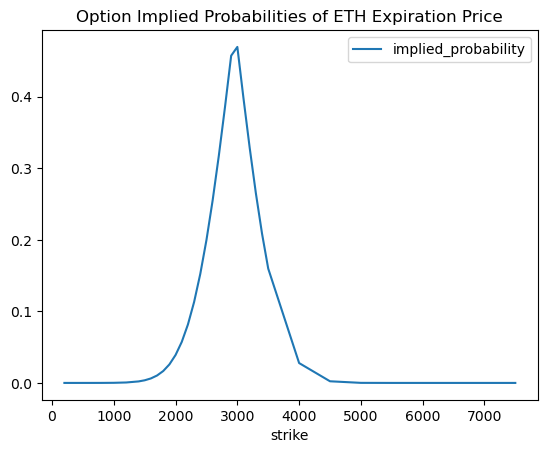

In [13]:
option_chain_full[['strike','implied_probability']].set_index('strike').plot(title='Option Implied Probabilities of ETH Expiration Price')

In [14]:
start = int(pd.to_datetime('20221231').timestamp()*1000)
end = int(pd.datetime.today().timestamp()*1000)
timeframe = '1D'